<a href="https://colab.research.google.com/github/ShiraGoren100/DeepLearning_Xray_analysis/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1 - Classification Neural Networks

### **Dataset**

In [ ]:
!pip install opendatasets
!pip install pandas

Download the dataset

In [ ]:
import opendatasets as od
import pandas

In [ ]:

od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shiragoren
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [01:43<00:00, 23.8MB/s]


Import packages

In [ ]:
# load packages
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
import numpy as np
import os
import shutil
import random

### **UNIFY AND DIVIDE DATASET**

Redistribution of the data into a training set and a validation set.

In [ ]:
# Set the paths for train and validation directories
normal = "NORMAL"
pneum = "PNEUMONIA"
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
val_dir = "/content/chest-xray-pneumonia/chest_xray/val"
merged_dir = "/content/chest-xray-pneumonia/chest_xray/merged"
merged_dir_n = "/content/chest-xray-pneumonia/chest_xray/merged/NORMAL"
merged_dir_p = "/content/chest-xray-pneumonia/chest_xray/merged/PNEUMONIA"

# Create a merged directory if it doesn't exist
for dir in [merged_dir, merged_dir_n, merged_dir_p]:
  if not os.path.exists(dir):
      os.makedirs(dir)

# Function to move files from source directory to destination directory
def move_files(source_dir, dest_dir):
    files = os.listdir(source_dir)
    for file in files:
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir, file))

# Merge train and validation samples into a single directory
for subdir in [normal, pneum]:
  move_files(os.path.join(train_dir,subdir), os.path.join(merged_dir,subdir))
  move_files(os.path.join(val_dir,subdir), os.path.join(merged_dir,subdir))

# Get the list of all files in the merged directory
normal_samples = os.listdir(merged_dir_n)
pneum_samples = os.listdir(merged_dir_p)

# Shuffle the list of files
random.shuffle(normal_samples)
random.shuffle(pneum_samples)

# Calculate the number of files for train and validation sets
for samples, subdir in zip([normal_samples, pneum_samples], [normal, pneum]):
  total_samples = len(samples)
  train_split = int(0.8 * total_samples)
  val_split = total_samples - train_split

  # Create train and validation directories
  train_dest = os.path.join(train_dir,subdir)
  val_dest = os.path.join(val_dir,subdir)
  src_dir = os.path.join(merged_dir, subdir)
  os.makedirs(train_dest, exist_ok=True)
  os.makedirs(val_dest, exist_ok=True)

  # Move files to train and validation directories based on the split ratio
  train_files = samples[:train_split]
  val_files = samples[train_split:]

  for file in train_files:
      shutil.move(os.path.join(src_dir, file), os.path.join(train_dest, file))

  for file in val_files:
      shutil.move(os.path.join(src_dir, file), os.path.join(val_dest, file))

Divide training set PHNEUMONIA file into 2 files: BACTERIA and VIRUS

In [ ]:
# Function to split data into 3 files
def split_data(source_dir, destination_bacterial_dir, destination_viral_dir):

    # Create destination directories if they don't exist
    if not os.path.exists(destination_bacterial_dir):
        os.makedirs(destination_bacterial_dir)
    if not os.path.exists(destination_viral_dir):
        os.makedirs(destination_viral_dir)

    # Loop through the images in the pneumonia directory
    for filename in os.listdir(source_dir):
        if 'bacteria' in filename:
            # Copy bacterial pneumonia images to the bacterial directory
            shutil.copy(os.path.join(source_dir, filename), os.path.join(destination_bacterial_dir, filename))
        elif 'virus' in filename:
            # Copy viral pneumonia images to the viral directory
            shutil.copy(os.path.join(source_dir, filename), os.path.join(destination_viral_dir, filename))

In [ ]:
# split data for train, val and test

# Define source and destination directories for training set
source_dir_tr = './chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
destination_bacterial_dir_tr = './chest-xray-pneumonia/chest_xray/train/BACTERIA'
destination_viral_dir_tr = './chest-xray-pneumonia/chest_xray/train/VIRUS'
split_data(source_dir_tr, destination_bacterial_dir_tr, destination_viral_dir_tr)

# Define source and destination directories for validation set
source_dir_v = './chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
destination_bacterial_dir_v = './chest-xray-pneumonia/chest_xray/val/BACTERIA'
destination_viral_dir_v = './chest-xray-pneumonia/chest_xray/val/VIRUS'
split_data(source_dir_v, destination_bacterial_dir_v, destination_viral_dir_v)

# Define source and destination directories for test set
source_dir_te = './chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
destination_bacterial_dir_te = './chest-xray-pneumonia/chest_xray/test/BACTERIA'
destination_viral_dir_te = './chest-xray-pneumonia/chest_xray/test/VIRUS'
split_data(source_dir_te, destination_bacterial_dir_te, destination_viral_dir_te)

### **1.1 Classification of healthy/sick**

Redistribution of the data into a training set and a validation set.

In [ ]:
# Set the paths for train and validation directories
normal = "NORMAL"
pneum = "PNEUMONIA"
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
val_dir = "/content/chest-xray-pneumonia/chest_xray/val"
merged_dir = "/content/chest-xray-pneumonia/chest_xray/merged"
merged_dir_n = "/content/chest-xray-pneumonia/chest_xray/merged/NORMAL"
merged_dir_p = "/content/chest-xray-pneumonia/chest_xray/merged/PNEUMONIA"

# Create a merged directory if it doesn't exist
for dir in [merged_dir, merged_dir_n, merged_dir_p]:
  if not os.path.exists(dir):
      os.makedirs(dir)

# Function to move files from source directory to destination directory
def move_files(source_dir, dest_dir):
    files = os.listdir(source_dir)
    for file in files:
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir, file))

# Merge train and validation samples into a single directory
for subdir in [normal, pneum]:
  move_files(os.path.join(train_dir,subdir), os.path.join(merged_dir,subdir))
  move_files(os.path.join(val_dir,subdir), os.path.join(merged_dir,subdir))

# Get the list of all files in the merged directory
normal_samples = os.listdir(merged_dir_n)
pneum_samples = os.listdir(merged_dir_p)

# Shuffle the list of files
random.shuffle(normal_samples)
random.shuffle(pneum_samples)

# Calculate the number of files for train and validation sets
for samples, subdir in zip([normal_samples, pneum_samples], [normal, pneum]):
  total_samples = len(samples)
  train_split = int(0.8 * total_samples)
  val_split = total_samples - train_split

  # Create train and validation directories
  train_dest = os.path.join("/content/chest-xray-pneumonia/chest_xray/train_split",subdir)
  val_dest = os.path.join("/content/chest-xray-pneumonia/chest_xray/val_split",subdir)
  src_dir = os.path.join(merged_dir, subdir)
  os.makedirs(train_dest, exist_ok=True)
  os.makedirs(val_dest, exist_ok=True)

  # Move files to train and validation directories based on the split ratio
  train_files = samples[:train_split]
  val_files = samples[train_split:]

  for file in train_files:
      shutil.move(os.path.join(src_dir, file), os.path.join(train_dest, file))

  for file in val_files:
      shutil.move(os.path.join(src_dir, file), os.path.join(val_dest, file))

#### Manual network

Create the model

In [ ]:
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)))
  model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
  return model

In [ ]:
datagen = image.ImageDataGenerator(rescale = 1./255)
train_gen = datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/train_split",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

print(train_gen.class_indices)

val_gen = datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/val_split",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

test_gen = datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

In [ ]:
model = define_model()

In [ ]:

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Evaluate the model

In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = model.evaluate(test_gen)
print("Test Accuracy:", test_accuracy)

Save the weights of the best model.

In [ ]:
model.summary()
# Save the trained model weights
model.save_weights('model_weights.h5')

#### Transfer learning:

In [ ]:
from keras.applications import VGG16

# Load pre-trained VGG16 model (excluding top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Create new model architecture
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = model.evaluate(test_gen)
print("Test Accuracy:", test_accuracy)

In [ ]:
model.summary()
# Save the trained model weights
model.save_weights('model_weights_transfer.h5')

In [ ]:
binary_class_model = model

### **1.2 Classification of healthy/bacterial pneumonia/viral pneumonia**

Delete files existing

In [ ]:

# # Define the directory path where the dataset was downloaded
# dataset_dir = './chest-xray-pneumonia'

# # Delete the directory and its contents
# shutil.rmtree(dataset_dir)

# print("Dataset download deleted successfully.")

Dataset download deleted successfully.


Divide training set PHNEUMONIA file into 2 files: BACTERIA and VIRUS

In [ ]:
# Function to create directories if they don't exist
def create_directories(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# #functin to split data into 3 files
# def split_data(source_dir, destination_bacterial_dir, destination_viral_dir):
#   # Download the dataset using opendatasets-if not downloaded yet
#   dataset_url = 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
#   od.download(dataset_url)


#   # Create destination directories
#   create_directories(destination_bacterial_dir)
#   create_directories(destination_viral_dir)

#   # Loop through the images in the pneumonia directory
#   for filename in os.listdir(source_dir):
#       if 'bacteria' in filename:
#           # Move bacterial pneumonia images to the bacterial directory
#           shutil.move(os.path.join(source_dir, filename), os.path.join(destination_bacterial_dir, filename))
#       elif 'virus' in filename:
#           # Move viral pneumonia images to the viral directory
#           shutil.move(os.path.join(source_dir, filename), os.path.join(destination_viral_dir, filename))


# Function to split data into 3 files, without ruiming PNEUMONIA file
def split_data(source_dir, destination_bacterial_dir, destination_viral_dir):
    # Download the dataset using opendatasets if not downloaded yet
    # Download the dataset using opendatasets-if not downloaded yet
    dataset_url = 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
    od.download(dataset_url)

    # Create destination directories if they don't exist
    if not os.path.exists(destination_bacterial_dir):
        os.makedirs(destination_bacterial_dir)
    if not os.path.exists(destination_viral_dir):
        os.makedirs(destination_viral_dir)

    # Loop through the images in the pneumonia directory
    for filename in os.listdir(source_dir):
        if 'bacteria' in filename:
            # Copy bacterial pneumonia images to the bacterial directory
            shutil.copy(os.path.join(source_dir, filename), os.path.join(destination_bacterial_dir, filename))
        elif 'virus' in filename:
            # Copy viral pneumonia images to the viral directory
            shutil.copy(os.path.join(source_dir, filename), os.path.join(destination_viral_dir, filename))

# Example usage:
source_dir = './chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
destination_bacterial_dir = './chest-xray-pneumonia/chest_xray/train/BACTERIA'
destination_viral_dir = './chest-xray-pneumonia/chest_xray/train/VIRUS'

split_data(source_dir, destination_bacterial_dir, destination_viral_dir)



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shiragoren
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:34<00:00, 71.2MB/s]


In [ ]:
# split data for train, val and test

# Define source and destination directories for training set
source_dir_tr = './chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
destination_bacterial_dir_tr = './chest-xray-pneumonia/chest_xray/train/BACTERIA'
destination_viral_dir_tr = './chest-xray-pneumonia/chest_xray/train/VIRUS'
split_data(source_dir_tr, destination_bacterial_dir_tr, destination_viral_dir_tr)

# Define source and destination directories for validation set
source_dir_v = './chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
destination_bacterial_dir_v = './chest-xray-pneumonia/chest_xray/val/BACTERIA'
destination_viral_dir_v = './chest-xray-pneumonia/chest_xray/val/VIRUS'
split_data(source_dir_v, destination_bacterial_dir_v, destination_viral_dir_v)

# Define source and destination directories for test set
source_dir_te = './chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
destination_bacterial_dir_te = './chest-xray-pneumonia/chest_xray/test/BACTERIA'
destination_viral_dir_te = './chest-xray-pneumonia/chest_xray/test/VIRUS'
split_data(source_dir_te, destination_bacterial_dir_te, destination_viral_dir_te)

In [ ]:
#check that training set was devided into files successfully
contents = os.listdir('./chest-xray-pneumonia/chest_xray/train')
# Print the list of contents
print("Contents of the directory:")
for item in contents:
    print(item)

print("Dataset organized successfully.")

Contents of the directory:
VIRUS
BACTERIA
PNEUMONIA
NORMAL
Dataset organized successfully.


Define model

In [ ]:
# Define the model
def define_model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(3, activation='softmax'))  # Three output classes: healthy, bacterial pneumonia, viral pneumonia
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#### Training funciton

In [ ]:

train_generator = train_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

val_generator = val_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

test_generator = test_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

Found 3104 images belonging to 3 classes.
Found 783 images belonging to 3 classes.
Found 476 images belonging to 3 classes.


In [ ]:


# Model definition and training
model2 = define_model2()
history = model2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]  # Early stopping to prevent overfitting
)
test_loss, test_accuracy = model2.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)



Epoch 1/10
98/98 [==============================] - 361s 4s/step - loss: 0.3348 - accuracy: 0.8595 - val_loss: 0.1148 - val_accuracy: 0.9629
Epoch 2/10
98/98 [==============================] - 353s 4s/step - loss: 0.1265 - accuracy: 0.9527 - val_loss: 0.2169 - val_accuracy: 0.9179
Epoch 3/10
98/98 [==============================] - 346s 4s/step - loss: 0.1081 - accuracy: 0.9595 - val_loss: 0.1142 - val_accuracy: 0.9483
Epoch 4/10
98/98 [==============================] - 340s 3s/step - loss: 0.0937 - accuracy: 0.9690 - val_loss: 0.1047 - val_accuracy: 0.9695
Epoch 5/10
98/98 [==============================] - 361s 4s/step - loss: 0.0828 - accuracy: 0.9751 - val_loss: 0.0856 - val_accuracy: 0.9669
Epoch 6/10
98/98 [==============================] - 364s 4s/step - loss: 0.0697 - accuracy: 0.9757 - val_loss: 0.0766 - val_accuracy: 0.9722
Epoch 7/10
98/98 [==============================] - 358s 4s/step - loss: 0.0578 - accuracy: 0.9796 - val_loss: 0.0700 - val_accuracy: 0.9735
Epoch 8/10
98

**TESTING**

Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# Predict classes for the test dataset
predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for the test dataset
true_classes = test_generator.classes
print(true_classes)
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


NameError: name 'model2' is not defined

In [ ]:
# Get the unique class labels from the true classes
unique_classes = np.unique(true_classes)
class_names=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
# Print the unique classes
print("Unique Classes:", unique_classes)

# Ensure that the number of unique classes matches the number of target names
if len(unique_classes) != len(class_names):
    print("Error: Number of unique classes does not match the number of target names.")
else:
    # Generate classification report
    class_report = classification_report(true_classes, predicted_classes, labels=unique_classes, target_names=class_names)
    print("Classification Report:")
    print(class_report)


Unique Classes: [0 1]
Error: Number of unique classes does not match the number of target names.


Precision, Recall, and F1 Score:

In [ ]:
from sklearn.metrics import classification_report
class_names=['NORMAL', 'BACTERIA', 'VIRAL']
# Get the unique class labels from the true classes
unique_classes = np.unique(true_classes)

# Generate classification report
class_report = classification_report(true_classes, predicted_classes, labels=unique_classes, target_names=class_names)
print("Classification Report:")
print(class_report)


ROC Curve and AUC:

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Evaluation

In [ ]:
val_loss, val_accuracy = model2.evaluate(val_generator)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = model2.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

24/24 [==============================] - 27s 1s/step - loss: 0.0713 - accuracy: 0.9762
Validation Accuracy: 0.9761589169502258
15/15 [==============================] - 16s 1s/step - loss: 1.7111 - accuracy: 0.6933
Test Accuracy: 0.6932772994041443


In [ ]:
model2.summary()
# Save the trained model weights
model2.save_weights('model_weights_part2.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

save weights to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in Drive where you have saved the code and datasets.
FOLDERNAME = 'deepLearningProj/'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


In [ ]:
import os

# List all files in the current directory
files = os.listdir('/content/deepLearningProj')

# Print the list of files
print("Files in the current directory:")
for file in files:
    print(file)


In [ ]:
import shutil

# Specify the source file path (where you loaded the weights from)
source_file_path = 'model_weights_part2.h5'

# Specify the destination directory in Google Drive
destination_directory = '/content/drive/My Drive/deepLearningProj/'

# Copy the file to Google Drive
shutil.copy(source_file_path, destination_directory)


'/content/drive/My Drive/deepLearningProj/model_weights_part2.h5'

chail transfer

In [ ]:
from keras.applications import VGG19

def define_model3():
  base_model2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


  # Freeze base layers
  for layer in base_model2.layers[:-5]:
      layer.trainable = False

  # Create new model architecture
  x = base_model2.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(base_model2.input, x)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
  return model

In [ ]:
# Data generators
train_datagen = image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.5, 1.5])
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

val_generator = val_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

test_generator = test_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

Found 3106 images belonging to 3 classes.
Found 781 images belonging to 3 classes.
Found 476 images belonging to 3 classes.


In [ ]:
binary_model2 = define_model3()
binary_model2.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
history = binary_model2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
98/98 [==============================] - 3673s 37s/step - loss: 0.6565 - accuracy: 0.6489 - val_loss: 0.6367 - val_accuracy: 0.6667
Epoch 2/10
98/98 [==============================] - 3647s 37s/step - loss: 0.6382 - accuracy: 0.6667 - val_loss: 0.6366 - val_accuracy: 0.6667
Epoch 3/10
98/98 [==============================] - 3647s 37s/step - loss: 0.6378 - accuracy: 0.6667 - val_loss: 0.6365 - val_accuracy: 0.6667
Epoch 4/10
98/98 [==============================] - 3630s 37s/step - loss: 0.6375 - accuracy: 0.6667 - val_loss: 0.6366 - val_accuracy: 0.6667
Epoch 5/10
50/98 [==============>...............] - ETA: 25:19 - loss: 0.6374 - accuracy: 0.6667

In [ ]:
val_loss, val_accuracy = binary_model2.evaluate(val_generator)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = binary_model2.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

#### Transfer-learning

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Define your model
model_t = Sequential()
model_t.add(base_model)
model_t.add(Flatten())
model_t.add(Dense(64, activation='relu'))
model_t.add(Dropout(0.5))
model_t.add(Dense(3, activation='softmax'))


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Compile the model
model_t.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_t.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]  # Early stopping to prevent overfitting
)

Epoch 1/10
97/97 [==============================] - 59s 488ms/step - loss: 0.3319 - accuracy: 0.8950 - val_loss: 0.1226 - val_accuracy: 0.9579
Epoch 2/10
97/97 [==============================] - 45s 458ms/step - loss: 0.1240 - accuracy: 0.9601 - val_loss: 0.0563 - val_accuracy: 0.9821
Epoch 3/10
97/97 [==============================] - 44s 459ms/step - loss: 0.0955 - accuracy: 0.9639 - val_loss: 0.0801 - val_accuracy: 0.9693
Epoch 4/10
97/97 [==============================] - 44s 453ms/step - loss: 0.0792 - accuracy: 0.9675 - val_loss: 0.0414 - val_accuracy: 0.9847
Epoch 5/10
97/97 [==============================] - 44s 449ms/step - loss: 0.0636 - accuracy: 0.9794 - val_loss: 0.0643 - val_accuracy: 0.9706
Epoch 6/10
97/97 [==============================] - 43s 445ms/step - loss: 0.0779 - accuracy: 0.9723 - val_loss: 0.0449 - val_accuracy: 0.9796
Epoch 7/10
97/97 [==============================] - 45s 463ms/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.0462 - val_accuracy: 0.9834

In [ ]:
val_loss, val_accuracy = model_t.evaluate(val_generator)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = model_t.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

25/25 [==============================] - 8s 331ms/step - loss: 0.0462 - accuracy: 0.9834
Validation Accuracy: 0.9833971858024597
15/15 [==============================] - 11s 746ms/step - loss: 1.0066 - accuracy: 0.7668
Test Accuracy: 0.7668067216873169


In [ ]:
model_t.summary()
# Save the trained model weights
model_t.save_weights('model_weights_part2.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 16320579 (62.26 MB)
Trainable params: 1605891 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in Drive where you have saved the code and datasets.
FOLDERNAME = 'deepLearningProj/'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


In [ ]:
import shutil

# Specify the source file path (where you loaded the weights from)
source_file_path = 'model_weights_part2.h5'

# Specify the destination directory in Google Drive
destination_directory = '/content/drive/My Drive/deepLearningProj/'

# Copy the file to Google Drive
shutil.copy(source_file_path, destination_directory)

'/content/drive/My Drive/deepLearningProj/model_weights_part2.h5'

## Part 2 - KNN, T-SNE


get the two test generaters

In [ ]:
from keras.preprocessing import image

test_two_classes = test_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    target_size = (224,224),
    batch_size = 32,
    classes=['NORMAL', 'PNEUMONIA'] # Class labels
)


test_three_classes = test_datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['NORMAL', 'BACTERIA', 'VIRAL'] # Class labels
)

# Print class indices
print(test_two_classes.class_indices)
print(test_three_classes.class_indices)




NameError: name 'test_datagen' is not defined

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def drawTSNE1(file, classes, test_gen, model, perplex, lr):
  # Load the pre-trained model
  model.load_weights(file, by_name=True)


  # Extract embedding vectors for each image
  embeddings = []
  labels = []

  # Loop through the test dataset
  for images_batch, labels_batch in test_gen:
      embeddings_batch = model.predict(images_batch)
      embeddings.extend(embeddings_batch)
      labels.extend(labels_batch)
      if len(embeddings) >= len(test_gen.classes):
          break

  # Convert embeddings and labels to numpy arrays
  embeddings = np.array(embeddings)
  labels = np.array(labels)

  print("embeddings: ", embeddings.shape)


  # Initialize KNN classifier
  knn = KNeighborsClassifier(n_neighbors=5)

  # Train the KNN classifier
  knn.fit(embeddings, labels)

  # Predict labels for the embeddings
  predicted_labels = knn.predict(embeddings)

  # Visualize the embeddings using t-SNE
  tsne = TSNE(n_components=2, random_state=42, perplexity=perplex, learning_rate=lr)
  embeddings_tsne = tsne.fit_transform(embeddings)

    # Plotting the t-SNE visualization
  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 3), alpha=0.5)
  plt.colorbar(scatter, ticks=range(3), label='Class')
  plt.title('t-SNE Visualization of Embeddings')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.grid(True)

  # Create a legend
  class_labels = np.unique(labels)
  print(class_labels)
  print(classes)
  plt.legend(handles=scatter.legend_elements()[0], labels=[classes[int(label)] for label in class_labels], title='Class', loc='upper right')

  plt.show()



T-SNE

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def drawTSNE(file, classes, test_gen, model, perplex, lr):
    # Load the pre-trained model
    model.load_weights(file, by_name=True)

    # Extract embedding vectors for each image
    embeddings = []
    labels = []

    # Loop through the test dataset
    for images_batch, labels_batch in test_gen:
        embeddings_batch = model.predict(images_batch)
        embeddings.extend(embeddings_batch)
        labels.extend(labels_batch)
        if len(embeddings) >= len(test_gen.classes):
            break

    # Convert embeddings and labels to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Convert one-hot encoded labels to single class labels
    labels = np.argmax(labels, axis=1)

    # Initialize KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the KNN classifier
    knn.fit(embeddings, labels)

    # Predict labels for the embeddings
    predicted_labels = knn.predict(embeddings)


    # Visualize the embeddings using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplex, learning_rate=lr)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Plotting the t-SNE visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", len(classes)), alpha=0.5)
    plt.colorbar(scatter, ticks=range(len(classes)), label='Class')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)

    # Create a legend
    class_labels = np.unique(labels)
    print(classes)
    # Create a legend with all classes provided
    plt.legend(handles=scatter.legend_elements()[0], labels=classes, title='Class', loc='upper right')


    plt.show()



get the 2 models

In [ ]:
model1 = define_model()

model2 = define_model2()


NameError: name 'define_model' is not defined

show T-SNE graphs

T-SNE gragh for classification: NORMAL/BACTERIA/VIRUS

In [ ]:
# Define the path to your dataset directory
dataset_dir = '/content/chest-xray-pneumonia/chest_xray/'

# Create an ImageDataGenerator instance for loading the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test set
test_generator = test_datagen.flow_from_directory(
    dataset_dir + 'test/',
    target_size=(224, 224),  # Adjust the target size as needed
    batch_size=32,
    # class_mode=None,  # Set class_mode to None to disable label generation
    shuffle=False  # Disable shuffling to maintain the order of samples
)



drawTSNE('/content/deepLearningProj/model_weights_part2.h5', ['NORMAL', 'BACTERIA', 'VIRUS'], test_generator,model2, 20, 600)

T-SNE gragh for classification: NORMAL/PNEUMONIA

In [ ]:
# Define the path to your dataset directory
datagen = image.ImageDataGenerator(rescale = 1./255)
test_gen1 = datagen.flow_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    classes=['NORMAL', 'PNEUMONIA']
)
drawTSNE1('/content/deepLearningProj/model_weights.h5',['NORMAL', 'PNEUMONIA'], test_gen1, model2,10, 80)

In [ ]:
# finding all classes
import numpy as np
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset directory
dataset_dir = '/content/chest-xray-pneumonia/chest_xray/'

# Create an ImageDataGenerator instance for loading the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test set
test_generator = test_datagen.flow_from_directory(
    dataset_dir + 'test/',
    target_size=(224, 224),  # Adjust the target size as needed
    batch_size=32,
    # class_mode=None,  # Set class_mode to None to disable label generation
    shuffle=False  # Disable shuffling to maintain the order of samples
)

# Extract labels from the test set
test_labels = test_generator.classes

# Save the test labels to a file
np.save('test_labels.npy', test_labels)

# Create class indices dictionary
class_indices = {class_name: idx for idx, class_name in enumerate(test_generator.class_indices)}

# Save the class indices to a JSON file
with open('class_indices.json', 'w') as json_file:
    json.dump(class_indices, json_file)

# Step 1: Check Data Loading
    test_sample_count = test_generator.samples
    print("Number of samples in the test set:", test_sample_count)

    # Step 2: Inspect Data Preparation
    test_class_count = len(test_generator.class_indices)
    print("Number of classes in the test set:", test_class_count)

    # Step 3: Review Label Assignment
    print("Class indices in the test set:", test_generator.class_indices)


PYTORCH

Training Function

In [ ]:
def train_model(model, optimizer, criterion,
                nepochs, train_loader, val_loader):
  '''
  Train a pytorch model and evaluate it every epoch.
  Params:
  model - a pytorch model to train
  optimizer - an optimizer
  criterion - the criterion (loss function)
  nepochs - number of training epochs
  train_loader - dataloader for the trainset
  val_loader - dataloader for the valset
  '''
  train_losses, val_losses = [], []
  for e in range(nepochs):
      running_loss = 0
      running_val_loss = 0
      for images, labels in train_loader:

        print(len(images))
        print(labels)
        # Training pass
        model.train() # set model in train mode
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

      # Evalaute model on validation at the end of each epoch.
      val_loss = 0
      with torch.no_grad():
          for images, labels in val_loader:
              model.eval()
              output = model(images)
              val_loss = criterion(output, labels)
              running_val_loss += val_loss.item()

      # Track train loss and validation loss
      train_losses.append(running_loss/len(train_loader))
      val_losses.append(running_val_loss/len(val_loader))

      print("Epoch: {}/{}.. ".format(e+1, nepochs),
            "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
            "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))
  return train_losses, val_losses

Evaluate Function

In [ ]:
def evaluate_model(model, test_loader):
  '''
  Evaluate a model on the given dataloader.
  Params:
  model - a pytorch model to train
  val_loader - dataloader for the valset
  '''
  validation_accuracy = 0
  with torch.no_grad():
      for images, labels in test_loader:
          # forward pass
          log_ps = model(images)
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          # count correct predictions
          equals = top_class == labels.view(*top_class.shape)

          validation_accuracy += torch.sum(equals.type(torch.FloatTensor))
  res = validation_accuracy/len(test_loader.dataset)
  return res

Convolutional Network

In [ ]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        print("IN FORWARD:")
        print(x.shape)
        x = self.conv1(x) # conv 1
        x = F.max_pool2d(x, 2) # max pooling 1
        x = F.relu(x) # relu
        x = self.conv2(x) # conv 2
        x = F.max_pool2d((x), 2) # max pooling 2
        x = F.relu(x) # relu
        x = x.view(-1, 320) # flatten input
        x = self.fc1(x) # hidden layer 1
        x = F.relu(x) # relu
        x = self.fc2(x) # hidden layer 2
        print(x)
        print(x.shape)
        return F.sigmoid(x) #output

cnn_model = ConvolutionalNet()
print(cnn_model)

In [ ]:
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),
])

# Define the paths to the datasets
train_data_dir = "/content/chest-xray-pneumonia/chest_xray/train"
val_data_dir = "/content/chest-xray-pneumonia/chest_xray/val"
test_data_dir = "/content/chest-xray-pneumonia/chest_xray/test"

# Create datasets from the Image folders
train_set = datasets.ImageFolder(root=train_data_dir, transform=transform)
val_set = datasets.ImageFolder(root=val_data_dir, transform=transform)
test_set = datasets.ImageFolder(root=test_data_dir, transform=transform)

# DEBUG
print(len(train_set))
print(train_set[0][0].shape)
batch_s = 64

# create data loader for the trainset (batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_s, shuffle=True)

# create data loader for the valset (batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_s, shuffle=True)

# create data loader for the testset (batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_s, shuffle=True)

In [ ]:
# set hyperparameters
cnn_nepochs = 3
cnn_learning_rate = 0.001
cnn_criterion = nn.BCELoss()

In [ ]:
# train the conv model
cnn_model = ConvolutionalNet()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate)

train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion,
                                       cnn_nepochs, train_loader, val_loader)

In [ ]:
# evaluate on the validation set
print(f"Validation accuracy: {evaluate_model(cnn_model, val_loader)}")

## Part 3 - Anomaly Detection

check images in directory

In [ ]:
import os

def find_num_pics(directory):
  # Check if the directory exists
  if os.path.exists(directory):
      # List all files in the directory
      files = os.listdir(directory)

      # Filter out only files with valid image extensions (e.g., JPEG, PNG)
      image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

      # Get the count of image files
      num_images = len(image_files)

      print("Number of images in the directory:", num_images)
  else:
      print("Directory not found:", directory)


train autoencoder on healthy images and calculate loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in Drive where you have saved the code and datasets.
FOLDERNAME = 'deepLearningProj/'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load images from the specified directory
def load_images(directory, target_size=(224, 224)):
    images = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        image = load_img(path, target_size=target_size)
        image = img_to_array(image) / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

In [ ]:


# Load healthy images (NORMAL) for training the autoencoder
healthy_images_dir = "/content/chest-xray-pneumonia/chest_xray/train/NORMAL"
find_num_pics(healthy_images_dir)
X_train_healthy = load_images(healthy_images_dir)
# print("x_train_healthy: ", X_train_healthy)
# Define the autoencoder model architecture
def create_autoencoder(input_shape):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    encoder = layers.MaxPooling2D((2, 2), padding='same')(encoder)
    encoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
    encoder = layers.MaxPooling2D((2, 2), padding='same')(encoder)
    encoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
    encoder_output = layers.MaxPooling2D((2, 2), padding='same')(encoder)

    # Decoder
    decoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_output)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder)

    # Create autoencoder model
    autoencoder = models.Model(encoder_input, decoder_output)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

# Create and compile the autoencoder model
input_shape = X_train_healthy[0].shape
autoencoder = create_autoencoder(input_shape)
autoencoder.summary()



Number of images in the directory: 1079
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)   

In [ ]:

# Train the autoencoder model
autoencoder.fit(X_train_healthy, X_train_healthy, epochs=10, batch_size=32)

# Evaluate the trained autoencoder model
losses = autoencoder.evaluate(X_train_healthy, X_train_healthy)
print("Autoencoder Loss:", losses)

# Define the path where you want to save the trained autoencoder model
autoencoder_model_path = "/content/autoencoder_model.h5"  # You can change the path as needed

# Save the trained autoencoder model to the specified path
autoencoder.save(autoencoder_model_path)

print("Autoencoder model saved at:", autoencoder_model_path)

In [ ]:
# Define the path to your Google Drive directory where you want to save the model
drive_path ='/content/drive/My Drive/deepLearningProj/'

# Define the name of the model file in Google Drive
model_filename = 'autoencoder_model.h5'

# Copy the model file to Google Drive
!cp {autoencoder_model_path} "{drive_path}/{model_filename}"

cp: cannot stat '{autoencoder_model_path}': No such file or directory


calculate loss

In [ ]:
# Load healthy images (NORMAL) for training the autoencoder
healthy_images_dir_v = "/content/chest-xray-pneumonia/chest_xray/val/NORMAL"
find_num_pics(healthy_images_dir_v)
X_val = load_images(healthy_images_dir_v)

# Load healthy images (NORMAL) for training the autoencoder
healthy_images_dir_t = "/content/chest-xray-pneumonia/chest_xray/test/NORMAL"
find_num_pics(healthy_images_dir_t)
X_test = load_images(healthy_images_dir_t)

# Evaluate the trained autoencoder model on the training data
train_loss = autoencoder.evaluate(X_train_healthy, X_train_healthy)
print("Autoencoder Training Loss:", train_loss)

# Evaluate the trained autoencoder model on the validation data
val_loss = autoencoder.evaluate(X_val, X_val)
print("Autoencoder Validation Loss:", val_loss)

# Evaluate the trained autoencoder model on the test data
test_loss = autoencoder.evaluate(X_test, X_test)
print("Autoencoder Test Loss:", test_loss)


Number of images in the directory: 270
Number of images in the directory: 234
34/34 [==============================] - 7s 75ms/step - loss: 0.0615
Autoencoder Training Loss: 0.06151524931192398
9/9 [==============================] - 1s 131ms/step - loss: 0.0609
Autoencoder Validation Loss: 0.060907993465662
8/8 [==============================] - 1s 123ms/step - loss: 0.0603
Autoencoder Test Loss: 0.06028377264738083


Calculate Reconstruction Error

In [ ]:
# Load images from the specified directory
def load_images(directory, target_size=(224, 224)):
    images = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        image = load_img(path, target_size=target_size)
        image = img_to_array(image) / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Function to print original and reconstructed images
def print_images_with_reconstruction(original_images, reconstructed_images, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))

    for i, index in enumerate(indices):
        axes[i, 0].imshow(original_images[index])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(reconstructed_images[index])
        axes[i, 1].set_title("Reconstructed Image")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


# Define directory paths
test_normal_dir = '/content/chest-xray-pneumonia/chest_xray/test/NORMAL'
test_pneumonia_dir = '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

# Load test images from NORMAL directory
X_test_normal = load_images(test_normal_dir)

# Load test images from PNEUMONIA directory
X_test_pneumonia = load_images(test_pneumonia_dir)

# Concatenate images from both directories
X_test = np.concatenate((X_test_normal, X_test_pneumonia), axis=0)

In [ ]:


# Load the trained autoencoder model
autoencoder = load_model('/content/deepLearningProj/autoencoder_model.h5')  # Replace with the actual path



In [ ]:

# # Calculate reconstruction error for each image
# reconstructed_images = autoencoder.predict(X_test)


In [ ]:
# Calculate reconstruction error for each image
batch_size = 8  # Define batch size
num_samples = len(X_test)
reconstructed_images = []

# Predict reconstructed images in batches
for i in range(0, num_samples, batch_size):
    batch = X_test[i:i+batch_size]
    batch_reconstructed = autoencoder.predict(batch)
    reconstructed_images.append(batch_reconstructed)

# Concatenate reconstructed images from all batches
reconstructed_images = np.concatenate(reconstructed_images, axis=0)


1/1 [==============================] - 0s 20ms/step


In [ ]:
reconstruction_errors = np.mean(np.square(X_test - reconstructed_images), axis=(1, 2, 3))

 find threshol, and classify image as sick/healthy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define threshold for anomaly detection
threshold = 0.0029 # Example threshold value

# Classify images as healthy or sick based on reconstruction error
predictions = ['healthy' if error <= threshold else 'sick' for error in reconstruction_errors]

# Create true labels based on the directory names
true_labels = ['healthy'] * len(X_test_normal) + ['sick'] * len(X_test_pneumonia)

# Convert predictions and true labels to binary format
binary_predictions = [1 if pred == 'sick' else 0 for pred in predictions]
binary_true_labels = [1 if label == 'sick' else 0 for label in true_labels]

# Calculate precision, recall, and F1-score
precision = precision_score(binary_true_labels, binary_predictions)
recall = recall_score(binary_true_labels, binary_predictions)
f1 = f1_score(binary_true_labels, binary_predictions)

# Print the results
# Evaluate the performance
accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.42948717948717946
Precision: 0.6808510638297872
Recall: 0.1641025641025641
F1-score: 0.2644628099173554


tests

In [ ]:
# Initialize counters
# correct_sick_predictions = 0
# false_sick_predictions = 0
# correct_healthy_predictions = 0
# false_healthy_predictions = 0
# # Iterate through predictions and true labels
# for i, (prediction, true_label) in enumerate(zip(predictions, true_labels)):
#     if prediction == 'sick' and true_label == 'sick':
#         correct_sick_predictions += 1
#     elif prediction == 'sick' and true_label == 'healthy':
#         false_sick_predictions += 1
#     elif prediction == 'healthy' and true_label == 'healthy':
#         correct_healthy_predictions += 1
#     elif prediction == 'healthy' and true_label == 'sick':
#         false_healthy_predictions += 1

# # Print the results
# print("Number of Correct Sick Predictions:", correct_sick_predictions)
# print("Number of False Sick Predictions:", false_sick_predictions)
# print("Number of Correct Healthy Predictions:", correct_healthy_predictions)
# print("Number of False Healthy Predictions:", false_healthy_predictions)

# # Calculate the number of correct predictions
# num_correct_predictions = correct_sick_predictions + correct_healthy_predictions

# # Calculate the number of incorrect predictions
# num_incorrect_predictions = false_sick_predictions + false_healthy_predictions

# # Calculate accuracy as the ratio of correct predictions to incorrect predictions
# accuracy = num_correct_predictions / (num_incorrect_predictions+num_correct_predictions)
# print("correct predictions: ", num_correct_predictions)
# print("false predictions: ", num_incorrect_predictions)
# print("Accuracy:", accuracy)

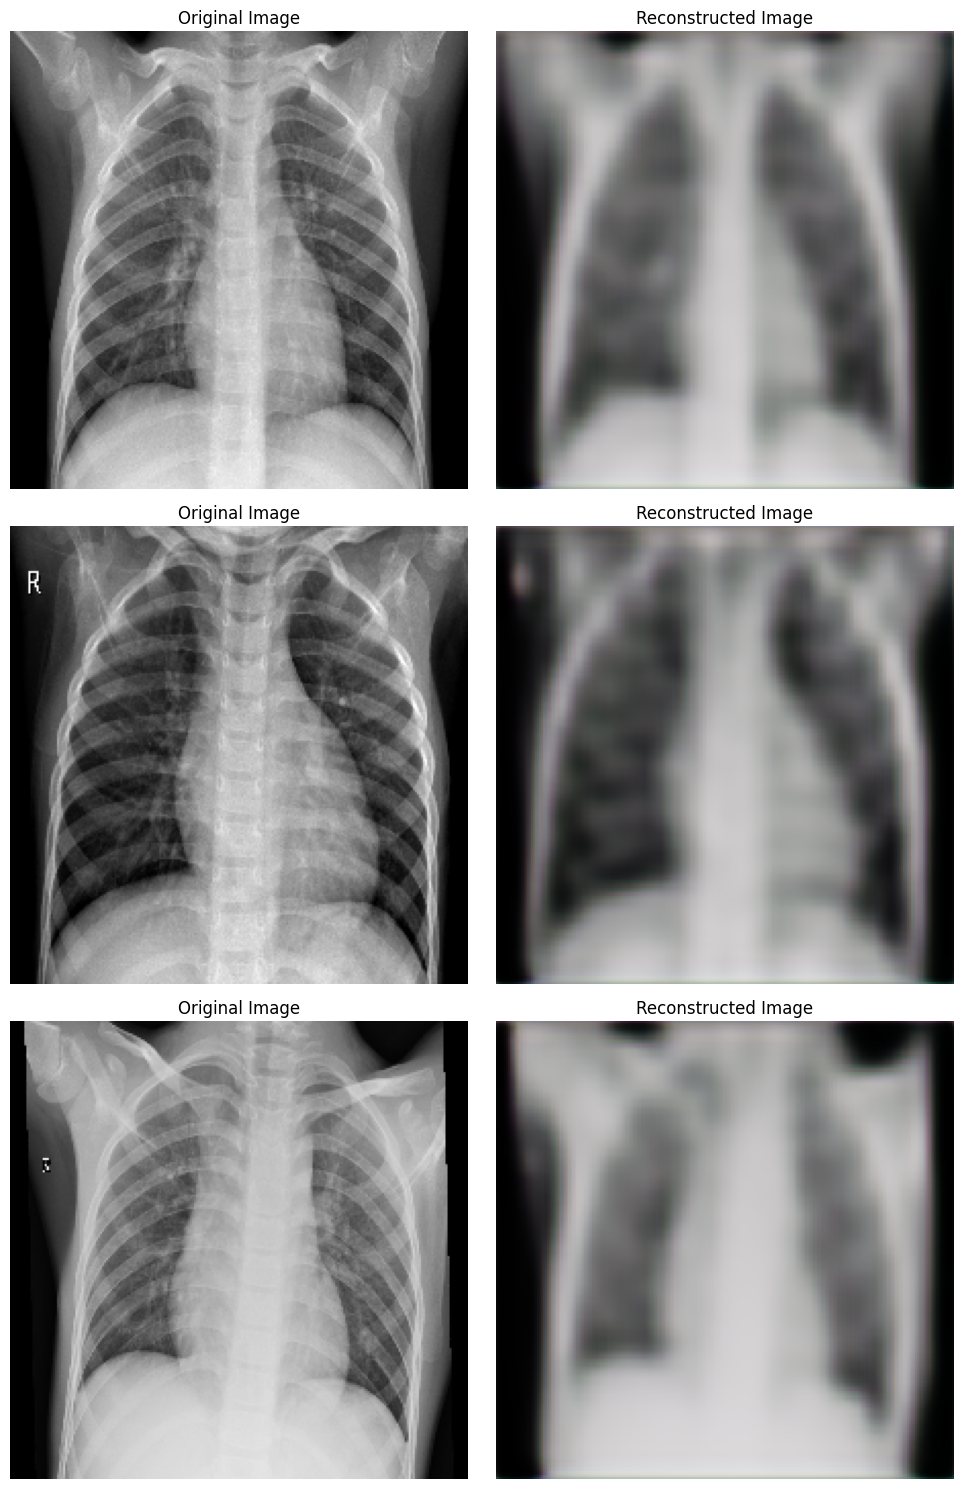

In [ ]:
# Print original and reconstructed images for a few samples
num_samples_to_print = 3  # Number of samples to print
indices_to_print = np.random.choice(len(X_test), num_samples_to_print, replace=False)
print_images_with_reconstruction(X_test, reconstructed_images, indices_to_print)

## Part 4 - Explainability

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the code and datasets.
# Recommended path: 'machine_learning_intro/assignments/assignment5/'
FOLDERNAME = 'deep_learning_proj/'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Load the model of task 1.1

In [ ]:
# load the model from the weights file
#model.load_weights("/content/deep_learning_proj/model_weights_transfer.h5")
model = define_model()
model.load_weights("/content/model_weights.h5")

Convert the target image to numpy array

In [ ]:
def get_img_array(img_path, size=(224,224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)

    # We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
img_size = (224, 224)
last_conv_layer_name = "conv2d_8"
input_layer_vgg16 = keras.Input(shape=(224, 224, 3), name='input_vgg16')

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, pred = grad_model(img_array)
        class_channel = pred[0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def create_heatmap_for_img(img_path, model):
  # Prepare image
  img_array = get_img_array(img_path, size=img_size)

  # Remove last layer's sigmoid
  model.layers[-1].activation = None

  # Print what the top predicted class is
  pred = model.predict(img_array)[0]
  print("Predicted:", pred)

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Display heatmap
  plt.matshow(heatmap)
  plt.show()

In [ ]:
def get_image_path(directory):

  # List all files in the directory
  files = os.listdir(directory)

  # Filter out non-image files (if needed)
  image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

  # Get the first image file
  image = image_files[10]

  # Construct the full path to the first image file
  image_path = os.path.join(directory, image)
  return image_path

1/1 [==============================] - 0s 77ms/step
Predicted: [5444.4956]


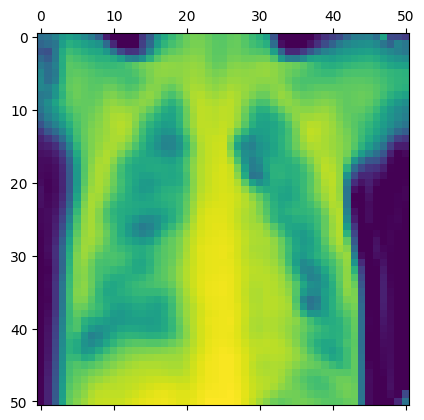

In [ ]:
sick_img = get_image_path("/content/chest-xray-pneumonia/chest_xray/train_split/PNEUMONIA")
create_heatmap_for_img(sick_img, model)

1/1 [==============================] - 0s 126ms/step
Predicted: [-163.34102]


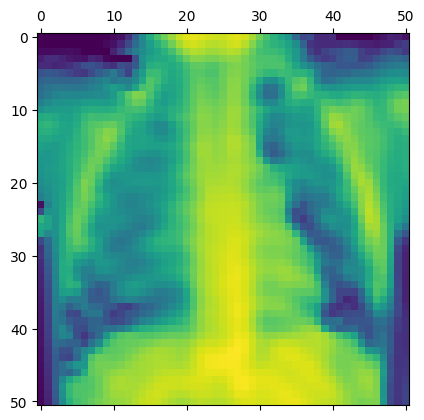

In [ ]:
normal_img = get_image_path("/content/chest-xray-pneumonia/chest_xray/train_split/NORMAL")
create_heatmap_for_img(normal_img, model)

## Heatmap by occlusion

In [ ]:
def generate_occlusion_heatmap(img_array, model, label_index, window_size=(20, 20), stride=(10, 10)):
    print("Image shape:", img_array.shape)
    print("Window size:", window_size)
    print("Stride:", stride)
    # Get the original prediction score
    pred_score = model.predict(np.expand_dims(img_array, axis=0))[0][label_index]

    # Initialize the heatmap with zeros
    heatmap = np.zeros((img_array.shape[0], img_array.shape[1]))

    # Iterate over the image with the specified window size and stride
    for y in range(0, img_array.shape[0] - window_size[0] + 1, stride[0]):
        for x in range(0, img_array.shape[1] - window_size[1] + 1, stride[1]):
            print("y:", y)
            print("x:", x)
            # Occlude the image with the window
            occluded_img = np.copy(img_array)
            occluded_img[y:y+window_size[0], x:x+window_size[1]] = 0  # Occlude the window region

            # Get the prediction score after occlusion
            occluded_score = model.predict(np.expand_dims(occluded_img, axis=0))[0][label_index]

            # Calculate the difference in prediction score
            diff_score = pred_score - occluded_score

            # Update the heatmap with the difference score
            heatmap[y:y+window_size[0], x:x+window_size[1]] += diff_score

    # Normalize the heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    return heatmap


In [ ]:
def get_image_heatmap(img_path, label_index):
  # Load the image
  img_array = get_img_array(img_path)

  # Generate the occlusion heatmap
  heatmap = generate_occlusion_heatmap(img_array, model, label_index=label_index)

  # Load and display the original image
  #display(Image(img_path))

  # Plot the heatmap
  plt.matshow(heatmap)
  plt.show()

In [ ]:
def get_image_path(directory):

  # List all files in the directory
  files = os.listdir(directory)

  # Filter out non-image files (if needed)
  image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

  # Get the first image file
  image = image_files[0]

  # Construct the full path to the first image file
  image_path = os.path.join(directory, image)
  return image_path

#normal_img = get_image_path("/content/chest-xray-pneumonia/chest_xray/train_split/NORMAL")

#get_image_heatmap(normal_img, 0)


Image shape: (224, 224, 3)
Window size: (20, 20)
Stride: (10, 10)
1/1 [==============================] - 1s 714ms/step
y: 0
x: 0
1/1 [==============================] - 1s 838ms/step
y: 0
x: 10
1/1 [==============================] - 1s 826ms/step
y: 0
x: 20
1/1 [==============================] - 1s 894ms/step
y: 0
x: 30
1/1 [==============================] - 1s 738ms/step
y: 0
x: 40
1/1 [==============================] - 1s 895ms/step
y: 0
x: 50
1/1 [==============================] - 1s 912ms/step
y: 0
x: 60
1/1 [==============================] - 1s 861ms/step
y: 0
x: 70
1/1 [==============================] - 1s 1s/step
y: 0
x: 80
1/1 [==============================] - 1s 1s/step
y: 0
x: 90
1/1 [==============================] - 1s 736ms/step
y: 0
x: 100
1/1 [==============================] - 0s 480ms/step
y: 0
x: 110
1/1 [==============================] - 0s 472ms/step
y: 0
x: 120
1/1 [==============================] - 0s 484ms/step
y: 0
x: 130
1/1 [==============================] - 0s

<ipython-input-16-7cd48f0f1fe8>:30: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))


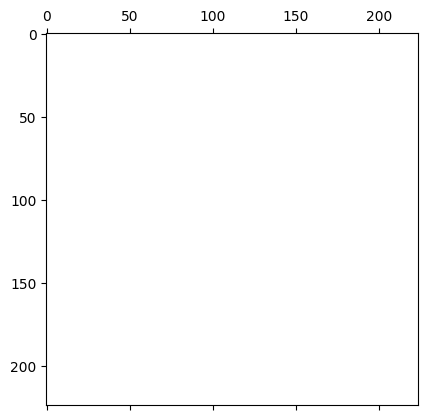

In [ ]:
sick_img = get_image_path("/content/chest-xray-pneumonia/chest_xray/train_split/PNEUMONIA")
get_image_heatmap(sick_img, 0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

model = binary_class_model

# Define Grad-CAM function
def grad_cam(model, img_path, layer_name):
    # Load and preprocess input image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get output and gradients
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer_name)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Generate heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Specify image path and layer name
img_path = 'path_to_your_image.jpg'
layer_name = 'block5_conv3'

# Compute Grad-CAM heatmap
heatmap = grad_cam(model, img_path, layer_name)

# Overlay heatmap onto input image
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Display original image and overlay
plt.imshow(img)
plt.imshow(superimposed_img)
plt.show()
